In [2]:
import os
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.Wordle import Wordle

In [7]:
# word list with frequencies
wl = pd.read_csv(r'..\data\processed\wordle_google_freq_word_list.csv', index_col=0)

# Read in  Bags of Words matrices: 
with open(r'..\data\processed\bags_of_words.json', 'r') as infile:
    all_bow = json.load(infile, parse_int=False)
bow17 = all_bow['combined_wordle_google']
bowwordle = all_bow['all_wordle']
bowcur = all_bow['wordle_curated']
bowcur

{'0': {'a': 0.06090712742980561,
  'b': 0.07473002159827213,
  'c': 0.08552915766738661,
  'd': 0.04794816414686825,
  'e': 0.031101511879049675,
  'f': 0.05874730021598272,
  'g': 0.04967602591792657,
  'h': 0.029805615550755938,
  'i': 0.01468682505399568,
  'j': 0.008639308855291577,
  'k': 0.008639308855291577,
  'l': 0.03801295896328294,
  'm': 0.04622030237580994,
  'n': 0.015982721382289417,
  'o': 0.017710583153347732,
  'p': 0.061339092872570194,
  'q': 0.009935205183585313,
  'r': 0.04535637149028078,
  's': 0.15809935205183584,
  't': 0.06436285097192225,
  'u': 0.014254859611231102,
  'v': 0.018574514038876888,
  'w': 0.035853131749460046,
  'x': 0.0,
  'y': 0.002591792656587473,
  'z': 0.0012958963282937365},
 '1': {'a': 0.13131749460043196,
  'b': 0.006911447084233261,
  'c': 0.017278617710583154,
  'd': 0.008639308855291577,
  'e': 0.10453563714902808,
  'f': 0.0034557235421166306,
  'g': 0.005183585313174946,
  'h': 0.06220302375809935,
  'i': 0.08725701943844492,
  'j'

In [8]:
# Calculate likelihood of word based on letter frequency

def calc_lfl(word_list, bow, colname):
    """
    What does this calculated value even represent???
    
    Calculate Likelihood of word from Letter Frequency given in a bag of words 5x26 matrix 
        see BJA-01.2-make-word-lists
    """
    result = []
    for word in word_list:
        likelihood = 1
        for i, letter in enumerate(word):
            likelihood *= bow[str(i)][letter]
        result.append((word, likelihood))
    return pd.DataFrame(sorted(result, key=lambda x: x[1], reverse=True), columns=['w', colname]).set_index('w') 

In [9]:
bow17lfl = calc_lfl(wl.index, bow17, colname='all')
bowwordlelfl = calc_lfl(wl.loc[wl['in_wordle']].index, bowwordle, colname='wordle')
bowcurlfl = calc_lfl(wl.loc[wl['in_wordle_curated']].index, bowcur, colname='curated')

lfl = pd.concat([bow17lfl, bowwordlelfl, bowcurlfl], axis=1, sort=True)
lfl

,all,wordle,curated
aahed,1.292783e-06,1.043506e-06,NaN
aalii,2.016669e-06,9.487546e-07,NaN
aalto,2.266343e-06,NaN,NaN
aargh,9.972532e-07,8.513659e-07,NaN
aaron,3.922183e-06,NaN,NaN
...,...,...,...
zweig,5.382158e-09,NaN,NaN
zygal,1.580275e-08,1.441573e-08,NaN
zygon,1.589365e-08,1.043174e-08,NaN
zymes,2.560392e-07,3.646003e-07,NaN


In [10]:
# lfl.to_csv(r'..\data\processed\letter_freq_likelihoods.csv')

# Question

## What sequence of words provides the highest chance of finding greens and yellows, without repeating any letters (i.e. maximizing grays)? 

In [11]:
def contains_any(word1, word2, max_repeat=0):
    """ Check whether word1 contains any of the letters in word2. """
#     set_ = set(x for x in str2)
#     return 1 in [c in str1 for c in set_]
    return any(letter in word1 for letter in word2)

### Make a function that iterates through the top 200 words with highest letter-frequency probability and finds the sequence of 5 words that has no repeats 
### If it can't find a next word with no repeat, then take the word with just one repeat (i.e. len(set(word)) == 4) 
### Then sum the calculated letter-freq probabilities of all the words 

### This will give a probability of finding a green but it doesn't include the helpful contribution from simply covering more letters and finding more grays. 
### To account for grays, include a "if you have X gray letter, what % of words are excluded?"

# Very important! The dataset for this optimization must use the entire wordle list, but with their letter-freq probabilities calculated from the curated list. This doesn't exist in my datasets yet so calculate it. 
## Then use the top 200 from curated as starting points for the calculation.


In [25]:
data = wl.loc[wl['in_wordle'], ['in_wordle_curated']]
data['wp'] = calc_lfl(data.index, bowcur, colname='wp')   # wp = Word Probability from letter frequency

# tglp = Total Green Letter Probability
# sum of all probabilities of finding that letter in that position 
data['tglp'] = data.index.map(lambda x: total_green_letter_prob(x)) 
curated_sorted = data.sort_values(['in_wordle_curated', 'tglp'], ascending=False)
curated_words = curated_sorted.loc[curated_sorted['in_wordle_curated']].index
display(curated_words)
data = data.sort_values('tglp', ascending=False)
data['unique_letters'] = data.index.map(lambda x: len(set(x)))
data.head(10)

Index(['slate', 'sauce', 'slice', 'shale', 'saute', 'share', 'sooty', 'shine',
       'suite', 'crane',
       ...
       'lymph', 'jumbo', 'igloo', 'ethic', 'unzip', 'umbra', 'affix', 'ethos',
       'inbox', 'nymph'],
      dtype='object', name='w', length=2315)

,in_wordle_curated,wp,tglp,unique_letters
w,,,,
saree,False,0.000037,0.680346,4
sooey,False,0.000043,0.678618,4
soree,False,0.000034,0.669546,4
saine,False,0.000034,0.666091,5
soare,False,0.000030,0.660043,5
saice,False,0.000029,0.653132,5
sease,False,0.000030,0.652268,3
seare,False,0.000026,0.644060,4
seine,False,0.000027,0.639309,4


In [15]:
def total_green_letter_prob(word, bow=bowcur):
    # Finds total probability that you will get at least 1 green in any position by testing this word
    prob = 0
    for i, letter in enumerate(word):
        prob += bow[str(i)][letter]
    return prob

def prob_of_2_greens(word):
    # How do you calculate this? 
    pass

def total_yellow_letter_prob(word):
    prob = 0  

In [17]:
all_words = [word.upper() for word in data.index]
counter = 0
for word in data[data['in_wordle_curated']].index:
    w = Wordle(word, ben_mode=False, all_words=[word.upper() for word in data.index])
    if w.try_word('saine')[0] > 0:
        counter += 1
counter

guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:

guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:

guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:

guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:  SAINE
guessed:

1163

In [22]:
total_green_letter_prob('saine', bow=bow17)

0.5711744761269524

In [19]:
counter/2315

0.5023758099352051

In [30]:
r = []
for word in curated_words:
    for c1, c2 in zip('saine', word):
        if c1 == c2:
            r.append(1)
            break
sum(r)

1163

In [31]:
1163/2315

0.5023758099352051

In [33]:
r = []
for word in curated_words:
    for c1, c2 in zip('saine', word):
        if c1 == c2:
            r.append(1)
#         break
sum(r)

1542

In [29]:
1542/2315

0.6660907127429806

# Be careful with calculating Total Green Letter Probability because it doesn't match up with the actual result from running Wordle on all words 



# The number you get from calculating by sum(bow[i][letter]) isn't actually the probability you'll get a get at least 1 green, it's the total number of greens you'll get across all words, which is a different metric but a useful one. 

<AxesSubplot:>

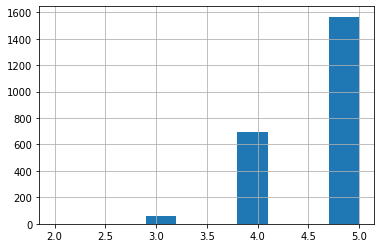

In [24]:
data[data['in_wordle_curated']]['unique_letters'].hist()

Text(0.5, 0, 'That weird letter-frequency calculation Ive been using')

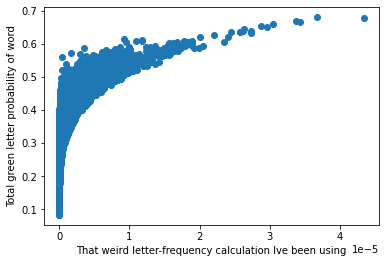

In [172]:
plt.scatter(data['wp'], data['tglp'])
plt.ylabel('Total green letter probability of word')
plt.xlabel('That weird letter-frequency calculation Ive been using')

In [196]:
sum_letter_prob('abcde') + \
sum_letter_prob('fghij') + \
sum_letter_prob('klmno') + \
sum_letter_prob('pqrst') + \
sum_letter_prob('uvwxy')

1.1740820734341253

In [151]:
# def calc_word_seq_prob(start_word, sequence):
#     prob = data.loc[start_word, 'lfp']
#     for word in sequence:
#         prob += 
    

result = []

for i, start_word in enumerate(start_words_list[0:5]):
    combined_words = start_word
    sequence = []
    for seq_index in range(5):
        for test_word, lfp in zip(data.index, data['lfp']): 
            if not contains_any(test_word, combined_words) and (len(set(test_word)) == 5):
                sequence.append((test_word, seq_index, lfp))
                combined_words += test_word
                break
            if test_word == 'xenia':
                # very last word was reached without finding a test_word with 5 unique letters
                # therefore it should test for len(set(test_word)) == 4
                for test_word, lfp in zip(data.index, data['lfp']): 
                    if not contains_any(test_word, combined_words) and (len(set(test_word)) > 2):
                        sequence.append((test_word, seq_index, lfp))
                        combined_words += test_word
                        break
    result.append((start_word, sequence))


In [152]:
result

[('saint',
  [('corey', 0, 1.56758292699267e-05), ('flump', 1, 2.583216898062418e-07)]),
 ('slate',
  [('crony', 0, 1.2852395246339025e-05),
   ('guimp', 1, 3.2586249930343075e-07)]),
 ('slice',
  [('brant', 0, 9.820479024269384e-06), ('podgy', 1, 1.2362713654154181e-06)]),
 ('sooty',
  [('crane', 0, 1.8836364893999484e-05), ('build', 1, 2.460836325918885e-06)]),
 ('crane',
  [('soily', 0, 2.408953110739327e-05), ('bumph', 1, 2.0517229207145907e-07)])]

In [ ]:
# Allow for x repeat letters
def contains_repeats(word, search, max_repeats):
    s = set(letter for letter in search)
    repeats = 0
    for letter in word:
        if letter in s:
            repeats += 1
    if repeats <= max_repeats:
        return True
    else:
        return False

In [20]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [56]:
# If you show that letter X is gray, what percent of words are excluded?
# incl dictionary gives what proportion of words contain that letter 
incldf = []
for wlist in [wl.index, 
              wl[wl['in_wordle']].index, 
              wl[wl['in_wordle_curated']].index]:
    incl = {letter: 0 for letter in alphabet}
    for word in wlist:
        for letter in incl:
            if letter in word:
                incl[letter] += 1
    for key, val in incl.items():
        incl[key] = val/len(wlist)
    incldf.append(incl)
incldf = pd.DataFrame(incldf).T
incldf.columns = ['all', 'wordle', 'curated']
incldf

,all,wordle,curated
a,0.435218,0.410885,0.392657
b,0.117559,0.117098,0.115335
c,0.144739,0.148011,0.193521
d,0.169974,0.177151,0.159827
e,0.447001,0.439793,0.456156
f,0.069757,0.076318,0.089417
g,0.117670,0.118949,0.129590
h,0.137902,0.131668,0.163715
i,0.290923,0.276673,0.279482
j,0.026513,0.022279,0.011663


In [113]:
# excldf gives proportion of words that DO NOT contain that letter 
excldf = []
for wlist in [wl.index, 
              wl[wl['in_wordle']].index, 
              wl[wl['in_wordle_curated']].index]:
    excl = {letter: 0 for letter in alphabet}
    for word in wlist:
        for letter in excl:
            if letter not in word:
                excl[letter] += 1
    for key, val in excl.items():
        excl[key] = val/len(wlist)
    excldf.append(excl)
excldf = pd.DataFrame(excldf).T
excldf.columns = ['all', 'wordle', 'curated']
excldf

,all,wordle,curated
a,0.564782,0.589115,0.607343
b,0.882441,0.882902,0.884665
c,0.855261,0.851989,0.806479
d,0.830026,0.822849,0.840173
e,0.552999,0.560207,0.543844
f,0.930243,0.923682,0.910583
g,0.882330,0.881051,0.870410
h,0.862098,0.868332,0.836285
i,0.709077,0.723327,0.720518
j,0.973487,0.977721,0.988337


In [89]:
pr = 1
for letter in 'saint':
    pr *= excldf.loc[letter, 'all']
pr

0.1391928277335598

In [86]:
c = 0
for word in wl.index:
    if not contains_any(word, 'saint'):
        c += 1
print(c)
c/17991

1986


0.1103885275971319

<AxesSubplot:>

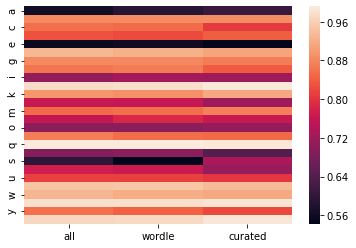

In [35]:
sns.heatmap(df)

In [ ]:
for i, (word, score) in enumerate(result[2:]):
    if contains_repeats(word, 'saintcoredbulky', 1) and (len(set(word)) >= 4):
        print(word, i)

# Question:

## When you calculate letter frequencies from the combined-wordle-google vs. all_wordle vs curated_wordle, how different are their likelihoods? 

## And how do those likelihoods vary when you look at all words, then look at only the curated words? 

In [111]:
wordle = lfl.loc[lfl['wordle'].notna()]
cur = lfl.loc[lfl['curated'].notna()]
cur

,all,wordle,curated,mean
saint,5.485123e-06,5.805338e-06,2.049619e-05,1.059555e-05
slate,4.525266e-06,5.031139e-06,2.001895e-05,9.858450e-06
slice,1.829480e-06,1.958015e-06,1.896764e-05,7.585044e-06
sooty,7.088772e-06,1.036034e-05,1.895991e-05,1.213634e-05
crane,3.608563e-06,3.497707e-06,1.883636e-05,8.647545e-06
...,...,...,...,...
bayou,8.593008e-08,5.578579e-08,3.027866e-09,4.824791e-08
inbox,3.798244e-09,2.536685e-09,2.677824e-09,3.004251e-09
askew,9.900721e-09,7.558942e-09,2.201108e-09,6.553590e-09
ninja,4.999918e-08,2.326241e-08,1.999967e-09,2.508719e-08


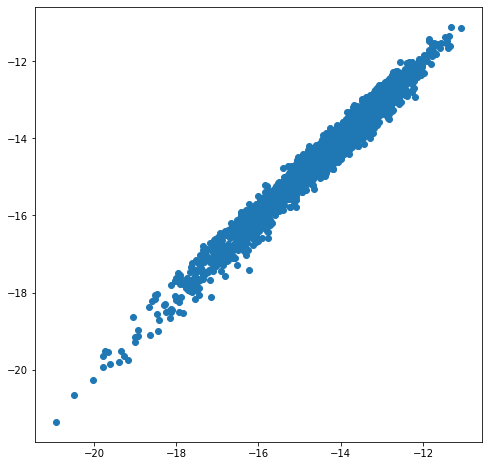

In [67]:
plt.scatter(np.log(cur['all']), np.log(cur['wordle']))
plt.gcf().set_size_inches((8,8))

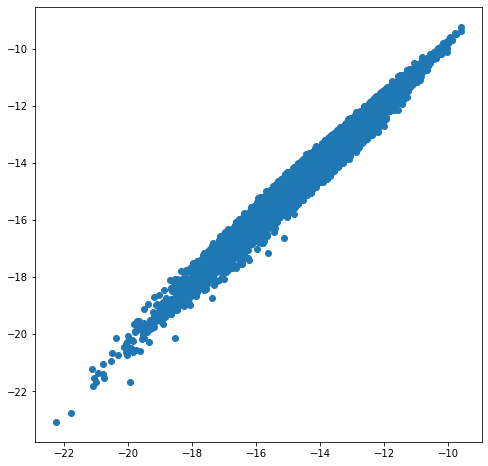

In [68]:
plt.scatter(np.log(wordle['all']), np.log(wordle['wordle']))
plt.gcf().set_size_inches((8, 8))

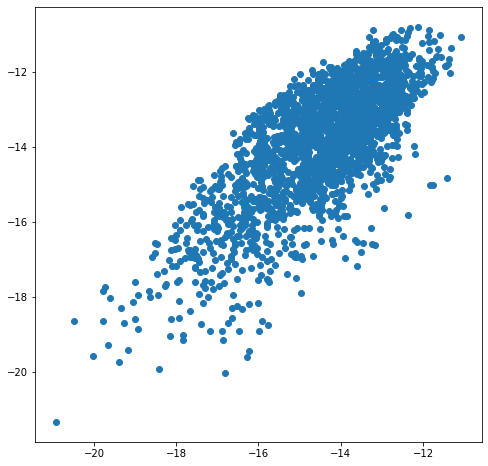

In [70]:
plt.scatter(np.log(cur['all']), np.log(cur['curated']))
plt.gcf().set_size_inches((8, 8))

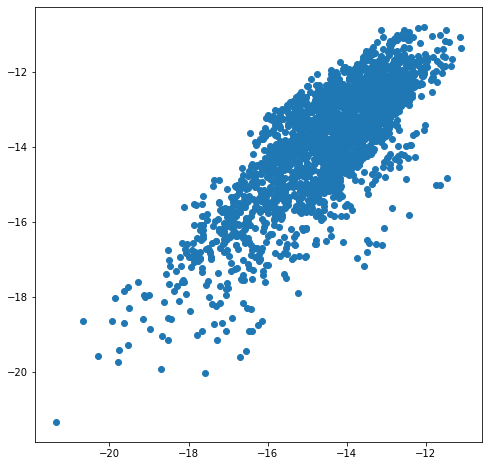

In [69]:
plt.scatter(np.log(cur['wordle']), np.log(cur['curated']))
plt.gcf().set_size_inches((8, 8))